In [1]:
import pandas_datareader as pdr
import pandas as pd
import numpy as np
import datetime
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # 한 실행칸에 프린트 여러개 해도 다 출력시키도록 하는 코드.
from scipy.optimize import minimize
from sklearn import linear_model
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from numpy import *

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


# Data Loading & preprocessing

In [2]:
_start = datetime(2015,1,1)
stock_list = ['005930.KS', '051910.KS', '005380.KS', '035420.KS', '017670.KS',
             '207940.KS', '068270.KS', '035720.KS', '006400.KS', '051900.KS']
row_data = pdr.get_data_yahoo(stock_list, start = _start)

In [3]:
row_data = row_data.xs('Close', axis = 1)

In [4]:
col_list = row_data.columns.to_list()
for i in col_list:
    row_data['logret_' + i[:-3]] = np.log(row_data[i] / row_data[i].shift(1)) * 100
    row_data.drop(i, axis = 1, inplace = True)
row_data
# kospi['log_ret'] = np.log(kospi['Adj Close'] / kospi['Adj Close'].shift(1))

Symbols,logret_005930,logret_051910,logret_005380,logret_035420,logret_017670,logret_207940,logret_068270,logret_035720,logret_006400,logret_051900
Date,,,,,,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,0.225310,-3.103211,-0.593474,2.432552,1.457221,NaN,-0.512218,5.183979,-1.724181,-1.302950
2015-01-06,-2.892135,-4.993695,-2.105341,-0.804294,-0.725956,NaN,-1.813543,0.552106,-3.540193,-0.657897
2015-01-07,0.922374,-0.907722,3.288787,-1.491553,-1.838287,NaN,-0.919107,1.976214,-0.451468,-0.995033
2015-01-08,0.534149,2.105341,4.598511,1.626052,-1.683856,NaN,0.526062,-0.609139,3.118293,2.143528
...,...,...,...,...,...,...,...,...,...,...
2020-10-08,-0.334448,1.749316,-1.375538,-1.320151,-0.415801,-0.835659,0.574164,-0.394997,1.243657,1.768798
2020-10-12,1.165708,-2.932762,-0.277393,-3.035646,-0.208551,0.557882,4.295712,-1.998734,-1.129956,2.880199
2020-10-13,0.824407,-4.255961,-0.557105,1.022155,1.244829,0.554786,-1.102952,0.134499,1.242252,-2.362063


In [5]:
today = datetime(datetime.today().year, datetime.today().month, datetime.today().day)
five_years_ago = today + relativedelta(years = -5)
row_data = row_data[row_data.index >= five_years_ago]

In [6]:
one_year_ago = today + relativedelta(years = -1)

In [7]:
train = row_data.loc[five_years_ago : one_year_ago]

In [8]:
cd91 = pd.read_csv('./CD91.csv')
cd91['rate'] = cd91['rate']/365 * 100 # 365(전체 일수), 252(영업 일수)
cd91['date'] = pd.to_datetime(cd91['date'])
cd91.set_index('date', inplace = True)
cd91.head()

,rate
date,
2009-01-02,1.076712
2009-01-05,1.073973
2009-01-06,1.073973
2009-01-07,1.073973
2009-01-08,0.890411


In [9]:
data = row_data.join(cd91, how='left')
data.fillna(method = 'ffill', inplace = True)
data.fillna(method = 'bfill', inplace = True)
data.dropna(inplace = True)

In [10]:
date_list = data.loc[one_year_ago:].index.to_list()

In [11]:
cd91_for_1year = data.loc[date_list[0]:, ].iloc[1:,-1]
cd91_for_1year

Date
2019-10-16    0.372603
2019-10-17    0.372603
2019-10-18    0.372603
2019-10-21    0.372603
2019-10-22    0.372603
                ...   
2020-10-08    0.172603
2020-10-12    0.172603
2020-10-13    0.172603
2020-10-14    0.172603
2020-10-15    0.172603
Name: rate, Length: 247, dtype: float64

# Calculating the sample covariance matrix

In [12]:
vcov = train.cov()

In [13]:
vcov # sample covariance matrix

Symbols,logret_005930,logret_051910,logret_005380,logret_035420,logret_017670,logret_207940,logret_068270,logret_035720,logret_006400,logret_051900
Symbols,,,,,,,,,,
logret_005930,2.564786,0.753039,0.159543,0.668498,0.037887,0.523345,0.358144,0.618493,1.204109,0.197399
logret_051910,0.753039,3.933329,0.409352,0.470498,0.248710,0.769002,0.766302,0.774121,2.163261,0.643152
logret_005380,0.159543,0.409352,3.013205,0.481673,0.201634,0.317924,0.025795,0.239785,0.241326,0.254821
logret_035420,0.668498,0.470498,0.481673,3.614916,-0.000225,0.451348,0.678593,1.059232,0.392893,0.523578
logret_017670,0.037887,0.248710,0.201634,-0.000225,1.900836,-0.053466,-0.102737,0.090192,0.210530,-0.015106
logret_207940,0.523345,0.769002,0.317924,0.451348,-0.053466,9.195496,3.532435,1.253770,1.130901,0.683063
logret_068270,0.358144,0.766302,0.025795,0.678593,-0.102737,3.532435,8.467411,1.441624,1.078073,1.181153
logret_035720,0.618493,0.774121,0.239785,1.059232,0.090192,1.253770,1.441624,4.567289,0.771827,0.591021
logret_006400,1.204109,2.163261,0.241326,0.392893,0.210530,1.130901,1.078073,0.771827,5.683600,0.651741


sample covariance matrix를 위와 같이 뽑을 수 있다.

<Figure size 1080x1080 with 0 Axes>

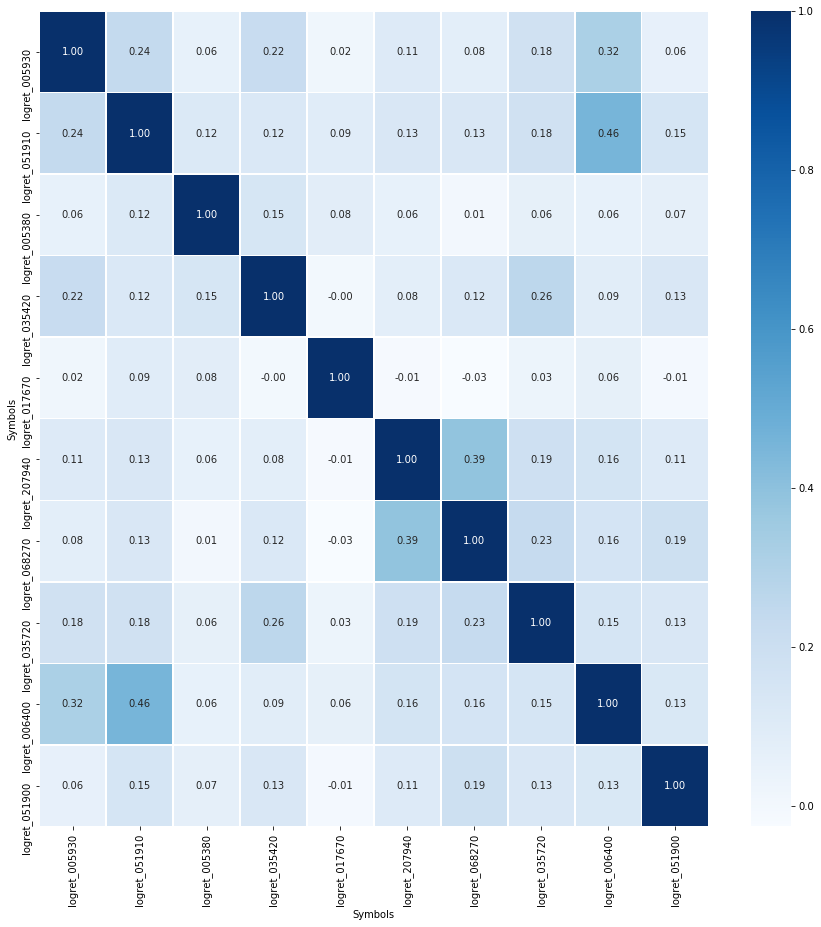

In [14]:
plt.figure(figsize=(15,15))
sns.heatmap(data = train.corr(), annot=True,
            fmt = '.2f', linewidths=.5, cmap='Blues') # heatmap of correlation matrix

In [15]:
n = len(row_data)
p = len(row_data.columns)

# Minimum variance portfolio

In [16]:
def constraint1(x):
    _sum = 0
    for i in range(len(x)):
        _sum += np.abs(x[i])
    return -(_sum - c)
    
    
def constraint2(x):
    _sum = 0
    for i in range(len(x)):
        _sum += x[i]
    return _sum - 1
    

In [17]:
def obj_func(x):
    return x.T @ vcov @ x

In [18]:
vcov = None
c = None
cons = [{'type': 'ineq', 'fun': constraint1},
        {'type': 'eq', 'fun': constraint2}]
def minimum_var_pf(data, _vcov = None, constraints = 1): # data : train data, vcov = variance-covariance matrix
    # constraints = 1 : No short sale
    global vcov, c
    c = constraints
    if _vcov is None:
        vcov = data.cov()
    else:
        vcov = _vcov
    inv_vcov = np.linalg.inv(vcov)
    w = inv_vcov @ np.ones(len(vcov))
    res = minimize(obj_func, w, constraints = cons, options = {'maxiter' : 10})
    w = res.x
    return w


In [19]:
minimum_var_pf(train)

array([ 0.27810657, -0.01418673,  0.20416767,  0.0988216 ,  0.44535868,
       -0.06530709, -0.00959942, -0.00645463, -0.08065322,  0.14974657])

now, repeat the above process with moving window for 1 year

In [20]:
data.loc[:date_list[1],:].iloc[1:,:-1]

,logret_005930,logret_051910,logret_005380,logret_035420,logret_017670,logret_207940,logret_068270,logret_035720,logret_006400,logret_051900
Date,,,,,,,,,,
2015-10-16,-0.315707,0.520383,-0.927364,3.114439,-0.386848,11.469184,3.441432,-0.778888,-2.777956,2.136113
2015-10-19,-0.714005,0.517689,0.000000,-0.512384,0.964328,11.469184,4.885551,0.260304,6.805346,-0.445932
2015-10-20,0.793026,0.000000,0.927364,-1.032711,-0.384616,11.469184,-0.129031,0.518584,3.871451,1.662088
2015-10-21,0.315458,1.197619,0.307220,-0.520383,0.192493,11.469184,0.000000,-0.518584,0.421053,0.875279
2015-10-22,0.784318,-1.197619,-0.615387,-4.992124,-3.323864,11.469184,-2.879760,-2.812136,-4.292504,-0.546151
...,...,...,...,...,...,...,...,...,...,...
2019-10-10,-0.718320,0.506330,-2.343857,0.000000,-0.854706,-0.916037,0.276514,1.476042,2.614528,-2.454111
2019-10-11,1.228265,1.834914,-0.396040,1.615544,1.490975,-0.307220,0.275752,-1.104984,-2.394021,-1.250016
2019-10-14,1.714616,0.494642,-3.226086,0.000000,0.000000,1.375117,0.549809,-0.371058,-0.220507,-0.789270


In [21]:
min_pf_ret = np.zeros((3, len(date_list)-1))
for idx, i in enumerate(date_list[:-1]):
    _data = data.loc[:i,:].iloc[idx:,:-1]
    target_data = data.loc[date_list[idx+1],:][:-1]
    print(i)
    _vcov = _data.cov()
    for j in range(3):
        weight = minimum_var_pf(_data, _vcov, constraints = j+1) # (10, 1)
        _ret = target_data @ weight
        min_pf_ret[j][idx] = _ret       

2019-10-15 00:00:00
2019-10-16 00:00:00
2019-10-17 00:00:00
2019-10-18 00:00:00
2019-10-21 00:00:00
2019-10-22 00:00:00
2019-10-23 00:00:00
2019-10-24 00:00:00
2019-10-25 00:00:00
2019-10-28 00:00:00
2019-10-29 00:00:00
2019-10-30 00:00:00
2019-10-31 00:00:00
2019-11-01 00:00:00
2019-11-04 00:00:00
2019-11-05 00:00:00
2019-11-06 00:00:00
2019-11-07 00:00:00
2019-11-08 00:00:00
2019-11-11 00:00:00
2019-11-12 00:00:00
2019-11-13 00:00:00
2019-11-15 00:00:00
2019-11-18 00:00:00
2019-11-19 00:00:00
2019-11-20 00:00:00
2019-11-21 00:00:00
2019-11-22 00:00:00
2019-11-25 00:00:00
2019-11-26 00:00:00
2019-11-27 00:00:00
2019-11-28 00:00:00
2019-11-29 00:00:00
2019-12-02 00:00:00
2019-12-03 00:00:00
2019-12-04 00:00:00
2019-12-05 00:00:00
2019-12-06 00:00:00
2019-12-09 00:00:00
2019-12-10 00:00:00
2019-12-11 00:00:00
2019-12-12 00:00:00
2019-12-13 00:00:00
2019-12-16 00:00:00
2019-12-17 00:00:00
2019-12-18 00:00:00
2019-12-19 00:00:00
2019-12-20 00:00:00
2019-12-23 00:00:00
2019-12-24 00:00:00


# Calculating the portfolio's variance and sharpe ratio

In [22]:
where_are_NaNs = isnan(min_pf_ret)
min_pf_ret[where_are_NaNs] = 0
min_pf_ret

array([[ 3.75262302e-01,  7.60755529e-02, -8.40104018e-01,
         5.69904066e-02,  5.85363704e-01, -1.07067206e-01,
         4.98767892e-01, -4.51302417e-01,  1.70471239e-02,
        -6.90001156e-01, -1.30915307e-01,  9.20629009e-01,
         8.43858928e-01,  7.28347594e-01,  4.70063621e-01,
         3.04829589e-01,  4.86796652e-01, -7.46179945e-01,
        -9.40214330e-01,  1.42846189e+00, -7.06602941e-01,
         1.70829790e+00,  3.77463209e-01, -4.73870879e-01,
        -9.25155633e-01, -9.43537010e-01,  4.43858136e-01,
         5.81713298e-01, -6.82872299e-01,  5.57478863e-01,
        -4.54028726e-02, -1.28326014e+00, -7.18873766e-01,
        -3.03388610e-01, -4.61000592e-01, -1.21885669e+00,
         1.21899879e+00,  1.31806764e+00,  2.67323937e-01,
         4.70369445e-02,  1.33061309e+00,  1.26797336e+00,
         9.09857136e-02,  1.10954830e+00, -2.22626360e-02,
        -1.30103667e-01,  4.93249698e-01, -1.03651668e+00,
        -6.12952268e-01,  4.25338178e-01, -3.01274573e-0

In [23]:
min_pf_var_1 = min_pf_ret[0].var()
min_pf_var_2 = min_pf_ret[1].var()
min_pf_var_3 = min_pf_ret[0].var()

min_pf_sharpe_1 = (min_pf_ret[0] - cd91_for_1year).mean()/min_pf_var_1
min_pf_sharpe_2 = (min_pf_ret[1] - cd91_for_1year).mean()/min_pf_var_2
min_pf_sharpe_3 = (min_pf_ret[2] - cd91_for_1year).mean()/min_pf_var_3

In [24]:
print('Variance of Minimum variance portfolio with gross-exposure constraints = 1 :', min_pf_var_1)
print('Variance of Minimum variance portfolio with gross-exposure constraints = 2 :', min_pf_var_2)
print('Variance of Minimum variance portfolio with gross-exposure constraints = 3 :', min_pf_var_3)

Variance of Minimum variance portfolio with gross-exposure constraints = 1 : 2.593445812445654
Variance of Minimum variance portfolio with gross-exposure constraints = 2 : 2.4389797717010593
Variance of Minimum variance portfolio with gross-exposure constraints = 3 : 2.593445812445654


In [25]:
print('Sharpe ratio of Minimum variance portfolio with gross-exposure constraints = 1 :', min_pf_sharpe_1)
print('Sharpe ratio of Minimum variance portfolio with gross-exposure constraints = 2 :', min_pf_sharpe_2)
print('Sharpe ratio of Minimum variance portfolio with gross-exposure constraints = 3 :', min_pf_sharpe_3)

Sharpe ratio of Minimum variance portfolio with gross-exposure constraints = 1 : -0.09386607194798403
Sharpe ratio of Minimum variance portfolio with gross-exposure constraints = 2 : -0.08818700710183347
Sharpe ratio of Minimum variance portfolio with gross-exposure constraints = 3 : -0.08293457508001689


sharpe ratio가 좋지 않다. 아마 선택된 종목의 차이인 것으로 보여진다.

# Thresholded covariance

In [26]:
def thresh_cov(data, h = 2): # data : Train data
    vcov = data.cov() # variance covariance matrix
    n, p = data.shape
    theta = np.zeros((p, p))
    # train_mean_np = data.mean(axis = 0).to_numpy()
    # data_mean = train_mean_np.reshape(1, -1).repeat(len(data), axis = 0)
    # center_x = data - data_mean
    center_x = data - data.mean()
    for i in range(p-1):
        for j in range(i+1, p):
            theta[i][j] = ((center_x.iloc[:,i] * center_x.iloc[:,j] - vcov.iloc[i,j])**2).mean()
    theta = theta + theta.T
    Index = vcov/np.sqrt(theta) > 2 * np.sqrt(np.log(p)/n)
    for i in range(p):
        Index.iloc[i,i] = True
    vcov_thresh = vcov * Index
    return vcov_thresh

In [27]:
minimum_var_pf(train, thresh_cov(train)) # an example of weights

array([0.1340601 , 0.02232222, 0.19263822, 0.06904313, 0.33416493,
       0.04583912, 0.00136441, 0.04855488, 0.00917756, 0.14283542])

now, repeat the above process with moving window for 1 year

In [28]:
thres_pf_ret = np.zeros((3, len(date_list)-1))
for idx, i in enumerate(date_list[:-1]):
    _data = data.loc[:i,:].iloc[idx:,:-1]
    target_data = data.loc[date_list[idx+1],:][:-1]
    print(i)
    _vcov = _data.cov()
    for j in range(3):
        weight = minimum_var_pf(_data, thresh_cov(_data), constraints = j+1) # (10, 1)
        _ret = target_data @ weight
        thres_pf_ret[j][idx] = _ret       

2019-10-15 00:00:00
2019-10-16 00:00:00
2019-10-17 00:00:00
2019-10-18 00:00:00
2019-10-21 00:00:00
2019-10-22 00:00:00
2019-10-23 00:00:00
2019-10-24 00:00:00
2019-10-25 00:00:00
2019-10-28 00:00:00
2019-10-29 00:00:00
2019-10-30 00:00:00
2019-10-31 00:00:00
2019-11-01 00:00:00
2019-11-04 00:00:00
2019-11-05 00:00:00
2019-11-06 00:00:00
2019-11-07 00:00:00
2019-11-08 00:00:00
2019-11-11 00:00:00
2019-11-12 00:00:00
2019-11-13 00:00:00
2019-11-15 00:00:00
2019-11-18 00:00:00
2019-11-19 00:00:00
2019-11-20 00:00:00
2019-11-21 00:00:00
2019-11-22 00:00:00
2019-11-25 00:00:00
2019-11-26 00:00:00
2019-11-27 00:00:00
2019-11-28 00:00:00
2019-11-29 00:00:00
2019-12-02 00:00:00
2019-12-03 00:00:00
2019-12-04 00:00:00
2019-12-05 00:00:00
2019-12-06 00:00:00
2019-12-09 00:00:00
2019-12-10 00:00:00
2019-12-11 00:00:00
2019-12-12 00:00:00
2019-12-13 00:00:00
2019-12-16 00:00:00
2019-12-17 00:00:00
2019-12-18 00:00:00
2019-12-19 00:00:00
2019-12-20 00:00:00
2019-12-23 00:00:00
2019-12-24 00:00:00


In [29]:
where_are_NaNs = isnan(thres_pf_ret)
thres_pf_ret[where_are_NaNs] = 0
thres_pf_ret

array([[ 1.05342295e-01, -1.14708534e-01, -4.96631090e-01,
         1.84071886e-01,  7.16644299e-01, -1.31987725e+00,
         3.41174636e-01, -6.34681290e-01, -2.04856133e-01,
        -7.19036032e-01, -7.29799206e-01,  7.29499042e-01,
         9.67369315e-01,  8.06916113e-01,  7.66665076e-01,
         3.35240664e-01,  8.21917409e-01, -7.33622445e-01,
        -7.56749729e-01,  1.80464955e+00, -5.94442375e-01,
         1.35903308e+00, -1.55298008e-01,  3.49914441e-02,
        -1.44762279e+00, -9.64752375e-01,  1.38357673e+00,
         3.53203031e-01, -6.96680640e-01,  5.59645943e-01,
        -3.36876107e-01, -1.45735513e+00, -6.29678753e-01,
        -5.15839912e-01, -4.37719477e-01, -7.23835037e-01,
         1.05780839e+00,  1.44109750e+00,  3.30360587e-01,
         3.44457473e-01,  1.25453170e+00,  1.25355253e+00,
        -1.19852039e-01,  2.05926246e+00,  2.37676055e-01,
        -1.65439286e-01,  8.02804480e-02, -1.29877725e+00,
        -5.74452499e-01,  9.42468333e-01, -1.38593350e+0

In [30]:
thres_pf_var_1 = thres_pf_ret[0].var()
thres_pf_var_2 = thres_pf_ret[1].var()
thres_pf_var_3 = thres_pf_ret[0].var()

thres_pf_sharpe_1 = (thres_pf_ret[0] - cd91_for_1year).mean()/thres_pf_var_1
thres_pf_sharpe_2 = (thres_pf_ret[1] - cd91_for_1year).mean()/thres_pf_var_2
thres_pf_sharpe_3 = (thres_pf_ret[2] - cd91_for_1year).mean()/thres_pf_var_3

In [31]:
print('Variance of Thresholded covariance portfolio with gross-exposure constraints = 1 :', thres_pf_var_1)
print('Variance of Thresholded covariance portfolio with gross-exposure constraints = 2 :', thres_pf_var_2)
print('Variance of Thresholded covariance portfolio with gross-exposure constraints = 3 :', thres_pf_var_3)

Variance of Thresholded covariance portfolio with gross-exposure constraints = 1 : 2.5550732422893425
Variance of Thresholded covariance portfolio with gross-exposure constraints = 2 : 2.446913756081782
Variance of Thresholded covariance portfolio with gross-exposure constraints = 3 : 2.5550732422893425


In [32]:
print('Sharpe ratio of Thresholded covariance portfolio with gross-exposure constraints = 1 :', thres_pf_sharpe_1)
print('Sharpe ratio of Thresholded covariance portfolio with gross-exposure constraints = 2 :', thres_pf_sharpe_2)
print('Sharpe ratio of Thresholded covariance portfolio with gross-exposure constraints = 3 :', thres_pf_sharpe_3)

Sharpe ratio of Thresholded covariance portfolio with gross-exposure constraints = 1 : -0.09648183835675399
Sharpe ratio of Thresholded covariance portfolio with gross-exposure constraints = 2 : -0.09040948218350223
Sharpe ratio of Thresholded covariance portfolio with gross-exposure constraints = 3 : -0.08658233430397705


sharpe ratio가 좋지 않다. 아마 선택된 종목의 차이인 것으로 보여진다.

# POET

In [33]:
def poet(data, num_eigen, _lambda = 1):
    vcov = data.cov()
    eigen_value, eigen_vector = np.linalg.eig(vcov) # Eigen value & Eigen vector
    factor_cov = eigen_vector[:,:num_eigen] @ np.diag(eigen_value[:num_eigen]) @ eigen_vector[:,:num_eigen].T
    sparse_input = vcov - factor_cov
    idx = np.zeros((p,p))

    #idx = i 변수와 j변수의 correlation의 절대값이 lambda보다 크면 1, 아니면 0
    for i in range(p):
        for j in range(p):
            idx[i][j] = 0
            if sparse_input.iloc[i,j]/np.sqrt(sparse_input.iloc[i,i]*sparse_input.iloc[j,j]) >= _lambda:
                idx[i][j] = 1
    sparse_cov = sparse_input*idx
    
    return factor_cov + sparse_cov

In [34]:
minimum_var_pf(train, poet(train, 5))

array([ 0.18139876,  0.04681334,  0.16881179,  0.0850199 ,  0.35188579,
        0.02384437,  0.05950637, -0.0005103 , -0.00188191,  0.0851119 ])

now, repeat the above process with moving window for 1 year

In [35]:
poet_pf_ret = np.zeros((3, len(date_list)-1))
for idx, i in enumerate(date_list[:-1]):
    _data = data.loc[:i,:].iloc[idx:,:-1]
    target_data = data.loc[date_list[idx+1],:][:-1]
    print(i)
    _vcov = _data.cov()
    for j in range(3):
        weight = minimum_var_pf(_data, poet(_data, 5), constraints = j+1) # (10, 1)
        _ret = target_data @ weight
        poet_pf_ret[j][idx] = _ret       

2019-10-15 00:00:00
2019-10-16 00:00:00
2019-10-17 00:00:00
2019-10-18 00:00:00
2019-10-21 00:00:00
2019-10-22 00:00:00
2019-10-23 00:00:00
2019-10-24 00:00:00
2019-10-25 00:00:00
2019-10-28 00:00:00
2019-10-29 00:00:00
2019-10-30 00:00:00
2019-10-31 00:00:00
2019-11-01 00:00:00
2019-11-04 00:00:00
2019-11-05 00:00:00
2019-11-06 00:00:00
2019-11-07 00:00:00
2019-11-08 00:00:00
2019-11-11 00:00:00
2019-11-12 00:00:00
2019-11-13 00:00:00
2019-11-15 00:00:00
2019-11-18 00:00:00
2019-11-19 00:00:00
2019-11-20 00:00:00
2019-11-21 00:00:00
2019-11-22 00:00:00
2019-11-25 00:00:00
2019-11-26 00:00:00
2019-11-27 00:00:00
2019-11-28 00:00:00
2019-11-29 00:00:00
2019-12-02 00:00:00
2019-12-03 00:00:00
2019-12-04 00:00:00
2019-12-05 00:00:00
2019-12-06 00:00:00
2019-12-09 00:00:00
2019-12-10 00:00:00
2019-12-11 00:00:00
2019-12-12 00:00:00
2019-12-13 00:00:00
2019-12-16 00:00:00
2019-12-17 00:00:00
2019-12-18 00:00:00
2019-12-19 00:00:00
2019-12-20 00:00:00
2019-12-23 00:00:00
2019-12-24 00:00:00


In [36]:
where_are_NaNs = isnan(poet_pf_ret)
poet_pf_ret[where_are_NaNs] = 0
poet_pf_ret

array([[ 5.20989294e-01,  1.39499673e-01, -8.27806032e-01,
         2.67215842e-02,  8.35696713e-01, -2.24030175e-01,
         5.58924650e-01, -4.47148727e-01,  4.67221778e-01,
        -4.90967380e-01, -1.26277531e-01,  8.99888775e-01,
         5.21427324e-01,  3.71837709e-01,  4.76731150e-01,
        -2.26861651e-01,  6.87654505e-01, -4.73506227e-01,
        -5.90267504e-01,  9.23598352e-01, -1.10034746e+00,
         1.94225181e+00,  3.20778968e-01, -5.10876241e-01,
        -8.76567380e-01, -9.96081677e-01,  4.35376355e-01,
         1.22436284e+00, -6.91964581e-01,  5.83693367e-01,
        -9.23316242e-02, -1.28375949e+00, -4.67016687e-01,
        -3.56960488e-02, -9.18991631e-01, -1.08387581e+00,
         8.23494248e-01,  4.55233533e-01,  3.11537449e-01,
        -3.84083625e-03,  8.75804302e-01,  6.26536511e-01,
         2.57177044e-01,  1.26938004e+00,  4.93409953e-02,
         2.61872209e-01,  5.28361759e-01, -1.45659502e-01,
        -6.26736144e-01,  4.66917785e-01, -6.26888782e-0

In [37]:
poet_pf_var_1 = poet_pf_ret[0].var()
poet_pf_var_2 = poet_pf_ret[1].var()
poet_pf_var_3 = poet_pf_ret[0].var()

poet_pf_sharpe_1 = (poet_pf_ret[0] - cd91_for_1year).mean()/poet_pf_var_1
poet_pf_sharpe_2 = (poet_pf_ret[1] - cd91_for_1year).mean()/poet_pf_var_2
poet_pf_sharpe_3 = (poet_pf_ret[2] - cd91_for_1year).mean()/poet_pf_var_3

In [38]:
print('Variance of Thresholded covariance portfolio with gross-exposure constraints = 1 :', poet_pf_var_1)
print('Variance of Thresholded covariance portfolio with gross-exposure constraints = 2 :', poet_pf_var_2)
print('Variance of Thresholded covariance portfolio with gross-exposure constraints = 3 :', poet_pf_var_3)

Variance of Thresholded covariance portfolio with gross-exposure constraints = 1 : 2.6186809722697832
Variance of Thresholded covariance portfolio with gross-exposure constraints = 2 : 2.6940627954722016
Variance of Thresholded covariance portfolio with gross-exposure constraints = 3 : 2.6186809722697832


In [39]:
print('Sharpe ratio of Thresholded covariance portfolio with gross-exposure constraints = 1 :', poet_pf_sharpe_1)
print('Sharpe ratio of Thresholded covariance portfolio with gross-exposure constraints = 2 :', poet_pf_sharpe_2)
print('Sharpe ratio of Thresholded covariance portfolio with gross-exposure constraints = 3 :', poet_pf_sharpe_3)

Sharpe ratio of Thresholded covariance portfolio with gross-exposure constraints = 1 : -0.09030407993515752
Sharpe ratio of Thresholded covariance portfolio with gross-exposure constraints = 2 : -0.08245806394825268
Sharpe ratio of Thresholded covariance portfolio with gross-exposure constraints = 3 : -0.08483171666272336


sharpe ratio가 좋지 않다. 아마 선택된 종목의 차이인 것으로 보여진다.